In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import seaborn as sns; sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
# Url to data hosted on github
# Original data source: https://www.kaggle.com/russellyates88/suicide-rates-overview-1985-to-2016?select=master.csv
data_url = 'https://raw.githubusercontent.com/KylunR/SuicideRateDataAnalysis/master/data.csv'


# Columns of data to read into
features = ["Country", "Year", "Sex", "Age", "Suicides_No", "Population", "Suicides/100K", 
            "Country_Year", "HDI", "GDP", "GDP_Per_Capita", "Generation"]


# Read data into features
data = pd.read_csv(data_url, names=features, sep=',', engine='python', na_values='?', skiprows=1)

# For testing, view table
#data.head()
data.tail()

,Country,Year,Sex,Age,Suicides_No,Population,Suicides/100K,Country_Year,HDI,GDP,GDP_Per_Capita,Generation
27815,Uzbekistan,2014,female,35-54 years,107,3620833,2.96,Uzbekistan2014,0.675,"63,067,077,179",2309,Generation X
27816,Uzbekistan,2014,female,75+ years,9,348465,2.58,Uzbekistan2014,0.675,"63,067,077,179",2309,Silent
27817,Uzbekistan,2014,male,5-14 years,60,2762158,2.17,Uzbekistan2014,0.675,"63,067,077,179",2309,Generation Z
27818,Uzbekistan,2014,female,5-14 years,44,2631600,1.67,Uzbekistan2014,0.675,"63,067,077,179",2309,Generation Z
27819,Uzbekistan,2014,female,55-74 years,21,1438935,1.46,Uzbekistan2014,0.675,"63,067,077,179",2309,Boomers


**Data Normalization**

In [3]:
# Data normalization

# Drop Country, Year, Country_Year, HDI
data.drop(['Country', 'Year', 'Country_Year', 'HDI'], axis=1, inplace=True)

# Replace Generation with int values
data.Generation.replace(['Boomers', 'Generation X', 'Generation Z', 'G.I. Generation', 'Millenials', 'Silent'], 
                        ['0', '1', '2', '3', '4', '5'], inplace=True)

# Replace male with 0, female with 1
data.Sex.replace(['male', 'female'], ['0', '1'], inplace=True)

# Remove commas from gdp value
data['GDP'] = data['GDP'].str.replace(',','')

# Used for finding averages of age range
def means(arr):
    return str(np.array(arr).mean())

# Replace age ranges with averages
data.Age.replace(['15-24 years', '25-34 years', '35-54 years', '5-14 years', '55-74 years', '75+ years'], 
                 [means([15, 24]), means([25, 34]), means([35, 54]), 
                  means([5, 14]), means([55, 74]), means([75])], inplace=True)

# Converting string values to numeric
pd.to_numeric(data['Generation']);
pd.to_numeric(data['Sex']);
pd.to_numeric(data['GDP']);


data.head()

,Sex,Age,Suicides_No,Population,Suicides/100K,GDP,GDP_Per_Capita,Generation
0,0,19.5,21,312900,6.71,2156624900,796,1
1,0,44.5,16,308000,5.19,2156624900,796,5
2,1,19.5,14,289700,4.83,2156624900,796,1
3,0,75.0,1,21800,4.59,2156624900,796,3
4,0,29.5,9,274300,3.28,2156624900,796,0


**Classification**

In [4]:
# Classification
# Using classification from: https://www.kaggle.com/elcaiseri/classification-of-high-low-suicide-rates

data['Fatality_Rate'] = np.where(data['Suicides/100K']>data['Suicides/100K'].mean(), 1, 0)


X = np.array(data.drop(['Fatality_Rate', 'Suicides/100K'], 1))
y = np.array(data.Fatality_Rate)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Model accuracy is: {0:.2f}".format(accuracy_score(y_test, y_pred) * 100))


Model accuracy is: 98.56


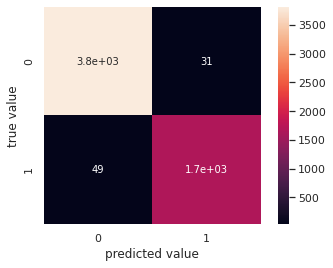

In [5]:
mat = confusion_matrix(y_test, y_pred)

sns.heatmap(mat, square=True, annot=True, cbar=True)

plt.xlabel('predicted value')
plt.ylabel('true value');

**Classification Analysis**

